In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import boto3
import io
from collections import defaultdict
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Waves

In [90]:
# ───────────── Settings ─────────────
BUCKET       = 'bdc-public-curated'
PREFIX       = 'ndacan/nytd/outcomes/waves_processed/'

# ───────────── Initialize S3 client & list files ─────────────
s3 = boto3.client('s3')

In [91]:
def s3_read_csv(key):
    """Load a CSV from S3 into a pandas DataFrame."""
    obj = s3.get_object(Bucket=BUCKET, Key=key)
    return pd.read_csv(io.BytesIO(obj['Body'].read()), dtype=str)

In [92]:
all_wave = s3_read_csv(f"{PREFIX}cleaned_all_waves.csv")

# All data: Afcars, service and waves

In [93]:
wave_service_afcars = pd.read_csv('nytd_final_modeling_data_20250724_090259(in).csv', dtype=str)

Used all wave dataset with _w1 and _w23 data calculated to replace _w1, _w2 and _w3

In [94]:
# Drop all columns that end with _w1, _w2, or _w3
wave_service_afcars = wave_service_afcars.drop(
    columns=[col for col in wave_service_afcars.columns if col.endswith(('_w1', '_w2', '_w3'))]
)

In [95]:
wave_service_afcars = all_wave.merge(wave_service_afcars, on='StFCID', how='left')

Check for correct merging

In [96]:
# Step 1: Get columns that came from the right side of the merge
right_only_cols = [col for col in wave_service_afcars.columns if col not in all_wave.columns or col == 'StFCID']

# Step 2: Identify rows where all right-side columns are NaN
unmatched_rows = wave_service_afcars[right_only_cols].isna().all(axis=1)

# Step 3: View or count them
num_unmatched = unmatched_rows.sum()
print(f"❗ Number of rows where wave_service_afcars data did not match (all NaNs): {num_unmatched}")

#see shape and size
print(wave_service_afcars.shape)

❗ Number of rows where wave_service_afcars data did not match (all NaNs): 0
(720, 96)


** StFIPS and Sex are bc one is a decimal and one is not **

In [97]:
# Function to strip common suffixes
def strip_suffix(col_name):
    return re.sub(r'(_x|_y)$', '', col_name)

# Group columns by base name
base_name_map = defaultdict(list)
for col in wave_service_afcars.columns:
    base = strip_suffix(col)
    base_name_map[base].append(col)

# Check which groups have identical values across all their versions
same_value_columns = {}

for base, cols in base_name_map.items():
    if len(cols) > 1:
        first_col = wave_service_afcars[cols[0]]
        identical = all(wave_service_afcars[c].equals(first_col) for c in cols[1:])
        same_value_columns[base] = identical

# Show only those that have identical values across versions
for base, is_identical in same_value_columns.items():
    if is_identical:
        print(f"✅ Columns with base '{base}' have identical values across all versions: {base_name_map[base]}")
    else:
        print(f"❌ Columns with base '{base}' have DIFFERENT values across: {base_name_map[base]}")


❌ Columns with base 'StFIPS' have DIFFERENT values across: ['StFIPS_x', 'StFIPS_y']
✅ Columns with base 'St' have identical values across all versions: ['St_x', 'St_y']
❌ Columns with base 'Sex' have DIFFERENT values across: ['Sex_x', 'Sex_y']
✅ Columns with base 'Cohort' have identical values across all versions: ['Cohort_x', 'Cohort_y']


Check all of csv for different matching  base-name column values

In [98]:
for base, cols in base_name_map.items():
    if len(cols) == 2 and not wave_service_afcars[cols[0]].equals(wave_service_afcars[cols[1]]):
        print(f"\n❌ Differences in {base}:")
        diffs = wave_service_afcars[
            ~wave_service_afcars[cols[0]].eq(wave_service_afcars[cols[1]]) & 
            ~(wave_service_afcars[cols[0]].isna() & wave_service_afcars[cols[1]].isna())
        ][cols]
        print(diffs)



❌ Differences in StFIPS:
    StFIPS_x StFIPS_y
0       47.0       47
1       47.0       47
2       47.0       47
3       47.0       47
4       47.0       47
..       ...      ...
309     47.0       47
310     47.0       47
311     47.0       47
312     47.0       47
313     47.0       47

[314 rows x 2 columns]

❌ Differences in Sex:
    Sex_x Sex_y
0     2.0     2
1     2.0     2
2     1.0     1
3     2.0     2
4     2.0     2
..    ...   ...
715   1.0     1
716   2.0     2
717   2.0     2
718   1.0     1
719   1.0     1

[720 rows x 2 columns]


In [99]:
wave_service_afcars = wave_service_afcars.rename(columns ={'Cohort_y' : 'Cohort', 'St_y' : 'St', 'StFIPS_y' : 'StFIPS', 'Sex_y' : 'Sex'})
wave_service_afcars = wave_service_afcars.drop(columns={'OutcmDte_w1', 'Cohort_x', 'St_x','StFIPS_x', 'Sex_x','RepDate_w1', 'RepDate_w23', 'Race_w1','OutcmDte_w23', 'StFIPS', 'HighEdCert_w1', 'HighEdCert_w23'})

In [100]:
wave_service_afcars.to_csv('wave_service_afcars.csv', index=False)

In [101]:
wave_service_afcars =pd.read_csv('wave_service_afcars.csv', dtype=str)

# Dictionaries 

##### Dependent (education & employment)

In [102]:
# Post secondary education
higher_education_columns = [
    'CurrenRoll_w1',
    'CurrenRoll_w23',
    'Voc_Certificate_w1',
    'Voc_Certificate_w23',
    'Voc_License_w1',
    'Voc_License_w23',
    'Assoc_Degree_w1',
    'Assoc_Degree_w23',
    'Bach_Degree_w1',
    'Bach_Degree_w23',
    'Higher_Degree_w1',
    'Higher_Degree_w23'
]

# Full time employment
full_time_employment_columns = [
    'CurrFTE_w1',
    'CurrFTE_w23'
]

# Full time employment and post secondary education
Emplyment_or_post_secondary = [ 
    'CurrenRoll_w1',
    'CurrenRoll_w23',
    'Voc_Certificate_w1',
    'Voc_Certificate_w23',
    'Voc_License_w1',
    'Voc_License_w23',
    'Assoc_Degree_w1',
    'Assoc_Degree_w23',
    'Bach_Degree_w1',
    'Bach_Degree_w23',
    'Higher_Degree_w1',
    'Higher_Degree_w23',
    'CurrFTE_w1',
    'CurrFTE_w23'
]

#### Independent

 Homelessness

In [103]:
# Late Homelessness
Homeless_wave_23 = ['Homeless_w23']
# Early Homelessness
Homeless = ['Homeless_w1', 'Homeless_w23']

#### Control

 Sex

In [104]:
sex = ['Sex']

Early Homeless

In [105]:
Early_homeless = ['Homeless_w1']

Race/Ethnicity

In [106]:
race_ethnicity_columns = [
    'White_Only',
    'Black_Only',
    'AI_AN_Only',     # American Indian / Alaska Native
    'Asian_Only',
    'PacIsl_Only',    # Pacific Islander
    'Multi_Race'
]


Disability

no clinical disability

In [107]:
disability_columns = [
    'DiagDis',       # Diagnosed Disability
]

Substance abuse & Incarceration

In [108]:
substance_abuse_columns = [
    'SubAbuse_w1',
    'SubAbuse_w23'
]

incarceration_columns = [
    'Incarc_w1',
    'Incarc_w23'
]

#### Services

In [109]:
service_columns = [
    'Service_Count'
]

#### Removal

In [110]:
removal_reason_columns = [
    'RR_neglect',
    'RR_abuse',
    'RR_other'
]


#### Placement

No current placement

In [111]:
# Where they are placed
placement_type_columns = [
    'PlacementType'
]

# How often they are moved
placement_instability_columns = [
    'PlacementInstability'  # Likely captures total placement changes
]


placement_instability_support = [
    'PlacementType',   # Can be used to track unique setting types
]

# How long they have been in foster care
months_in_foster_care_column = [
    'MonthsInCare'
]

# Descriptive Stats

In [112]:
# Generate descriptive stats
descriptive_stats = wave_service_afcars.describe(include='all').T

# Add a column for the column name
descriptive_stats = descriptive_stats.reset_index().rename(columns={'index': 'column_name'})

# Optional: display or save
print(descriptive_stats.head())

   column_name count unique             top freq
0       StFCID   720    720  TNµ®œ¿ˆ©¬«÷½û¥    1
1  OutcmRpt_w1   720      1               1  720
2  OutcmFCS_w1   720      1             1.0  720
3   CurrFTE_w1   710      2             0.0  702
4   CurrPTE_w1   711      2             0.0  640


In [113]:
descriptive_stats.to_csv('descriptive_stats.csv', index=False)

# Model 1

homelessness experience (wave 1) were associated with having post secondary eduction [control for factors prior to homeless] 

* higher_education_columns
* full_time_employment_columns 
* Emplyment_or_post_secondary 
* Homeless_wave_23 
* Homeless 
* Early_homeless

In [114]:
wave_service_afcars['PostSecEd_or_FTE'] = (
    wave_service_afcars[Emplyment_or_post_secondary].astype(str).eq('1').any(axis=1)
).astype(int)



In [115]:
independent_vars = Homeless_wave_23 
control_vars = Early_homeless
dependent_vars = Emplyment_or_post_secondary

In [116]:
# Prepare data for modeling
model_vars = independent_vars + control_vars
df_model = wave_service_afcars[model_vars + ['PostSecEd_or_FTE']]


In [117]:
# Step 2: Add constant
X = sm.add_constant(df_model[model_vars])

In [118]:
# Step 3: Ensure numeric and drop rows where conversion fails
X_clean = X.apply(pd.to_numeric, errors='coerce')
X_clean = X_clean.dropna()

In [119]:
# Step 4: Align y to X_clean
y = df_model.loc[X_clean.index, 'PostSecEd_or_FTE']

In [120]:
wave_service_afcars[Emplyment_or_post_secondary].head(10)

,CurrenRoll_w1,CurrenRoll_w23,Voc_Certificate_w1,Voc_Certificate_w23,Voc_License_w1,Voc_License_w23,Assoc_Degree_w1,Assoc_Degree_w23,Bach_Degree_w1,Bach_Degree_w23,Higher_Degree_w1,Higher_Degree_w23,CurrFTE_w1,CurrFTE_w23
0,1.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
1,1.0,0,0,0,0,0,0,0,0,0,0,0,0.0,1
2,1.0,0,0,0,0,0,0,0,0,0,0,0,0.0,1
3,1.0,0,0,0,0,0,0,0,0,0,0,0,0.0,1
4,1.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
5,1.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
6,1.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
7,1.0,1,0,0,0,0,0,0,0,0,0,0,0.0,1
8,1.0,1,0,0,0,0,0,0,0,0,0,0,0.0,0
9,1.0,1,0,0,0,0,0,0,0,0,0,0,0.0,0


In [121]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [122]:
# Step 5: VIF calculation

vif_data = pd.DataFrame()
vif_data["feature"] = X_clean.columns
vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) for i in range(X_clean.shape[1])]

# Output
print("📊 Variance Inflation Factors:")
print(vif_data)

📊 Variance Inflation Factors:
        feature       VIF
0         const  1.525385
1  Homeless_w23  1.001515
2   Homeless_w1  1.001515


In [123]:
pd.crosstab(wave_service_afcars['Homeless_w23'], wave_service_afcars['PostSecEd_or_FTE'])
pd.crosstab(wave_service_afcars['Homeless_w1'], wave_service_afcars['PostSecEd_or_FTE'])

PostSecEd_or_FTE,0,1
Homeless_w1,,
0.0,230,404
1.0,20,62


Logistic Regression

### Wald Test - for individual coefficients
checking for statistically sig effect on outcome variable

In [124]:
# Fit the model using clean, aligned data
logit_model = sm.Logit(y, X_clean)
result = logit_model.fit()

# Print the regression results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.627309
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:       PostSecEd_or_FTE   No. Observations:                  715
Model:                          Logit   Df Residuals:                      712
Method:                           MLE   Df Model:                            2
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:                 0.02947
Time:                        09:33:07   Log-Likelihood:                -448.53
converged:                       True   LL-Null:                       -462.15
Covariance Type:            nonrobust   LLR p-value:                 1.216e-06
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8148      0.100      8.127      0.000       0.618       1.011
Homeless_w23    -0.8104

In [125]:
# Extract summary data
summary_table = result.summary2().tables[1]  # Table with coefficients and p-values

# Filter significant variables (p < 0.05)
significant_vars = summary_table[summary_table['P>|z|'] < 0.05]

print("📌 Statistically Significant Variables (p < 0.05):")
print(significant_vars)


📌 Statistically Significant Variables (p < 0.05):
                 Coef.  Std.Err.         z         P>|z|    [0.025    0.975]
const         0.814848  0.100264  8.127029  4.399409e-16  0.618334  1.011362
Homeless_w23 -0.810428  0.170575 -4.751142  2.022715e-06 -1.144750 -0.476106
Homeless_w1   0.630356  0.274919  2.292878  2.185502e-02  0.091524  1.169187


In [126]:
significant_vars.to_csv('homeless_education_significant_vars.csv')

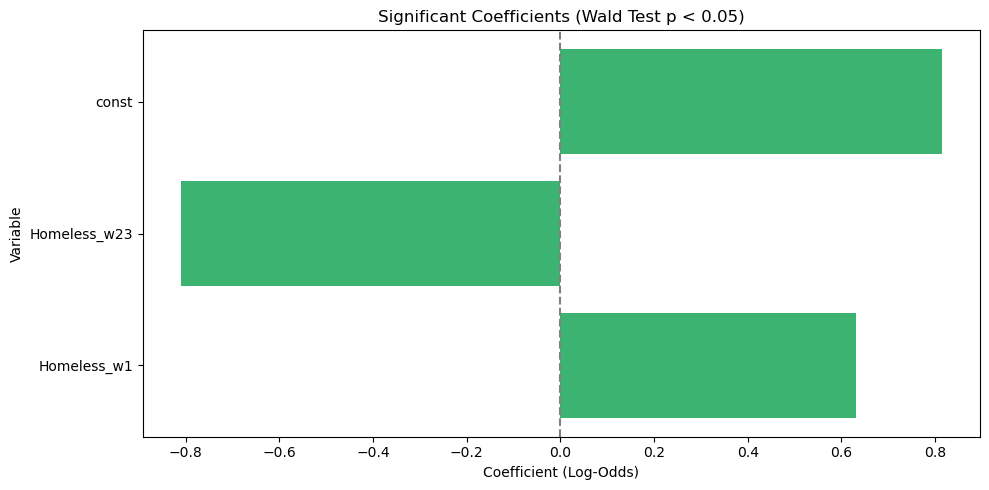

In [127]:
# Plot: Bar chart of significant coefficients
plt.figure(figsize=(10, 5))
plt.barh(significant_vars.index, significant_vars['Coef.'], color='mediumseagreen')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title("Significant Coefficients (Wald Test p < 0.05)")
plt.xlabel("Coefficient (Log-Odds)")
plt.ylabel("Variable")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

* Youth who are homeless post-transition have lower odds of being a full time employee or pursing education
* Youth homeless in pre-transition have higher odds of being employed/pursing education 


## Model 3
How Placement effects Homelessness

Independent
* PlacementType 
* PlacementInstability
* MonthsInCare

Dependent
* Homeless_23 

In [128]:
# STEP 1: Check your variables
X_cols = ['PlacementType', 'PlacementInstability', 'MonthsInCare']
y_col = 'Homeless_w23' 

In [129]:
# STEP 2: Select those columns
Model_3 = wave_service_afcars[X_cols + [y_col]].copy()

In [130]:
# One-hot encode PlacementType if categorical
Model_3 = pd.get_dummies(Model_3, columns=['PlacementType'], drop_first=True)


In [131]:
# STEP 4: Drop missing or infinite
Model_3 = Model_3.replace([np.inf, -np.inf], np.nan).dropna()

In [132]:
# STEP 6: Separate X and y
X = sm.add_constant(Model_3.drop(columns=[y_col])).astype(float)
y = Model_3[y_col].astype(int)  # Must be binary (0/1) and numeric

In [133]:
# Step 5: VIF calculation
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Output
print("📊 Variance Inflation Factors Model 3:")
print(vif_data)

📊 Variance Inflation Factors Model 3:
                feature       VIF
0                 const  4.741404
1  PlacementInstability  1.658104
2          MonthsInCare  1.696234
3       PlacementType_2  1.295408
4       PlacementType_3  1.321793


In [134]:
# STEP 7: Fit logistic regression
model3 = sm.Logit(y, X)
result3 = model3.fit()

Optimization terminated successfully.
         Current function value: 0.591627
         Iterations 5


In [135]:
# Output
print(result3.summary())

                           Logit Regression Results                           
Dep. Variable:           Homeless_w23   No. Observations:                  480
Model:                          Logit   Df Residuals:                      475
Method:                           MLE   Df Model:                            4
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:                 0.01687
Time:                        09:33:08   Log-Likelihood:                -283.98
converged:                       True   LL-Null:                       -288.85
Covariance Type:            nonrobust   LLR p-value:                   0.04494
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.2637      0.224     -5.639      0.000      -1.703      -0.825
PlacementInstability     0.0604      0.026      2.340      0.019       0.010       0.111
MonthsInCare

In [136]:
# Extract p-values
pvals = result3.pvalues

# Set alpha threshold
alpha = 0.05

# Filter to only significant variables
significant_vars = pvals[pvals < alpha]

# Create summary DataFrame for significant variables
model3_summary_sig = pd.DataFrame({
    'Variable': significant_vars.index,
    'Coefficient': result3.params[significant_vars.index],
    'P-Value': significant_vars.values,
    'CI Lower': result3.conf_int().loc[significant_vars.index][0].values,
    'CI Upper': result3.conf_int().loc[significant_vars.index][1].values
}).reset_index(drop=True)

# Show only significant predictors
print(model3_summary_sig)


               Variable  Coefficient       P-Value  CI Lower  CI Upper
0                 const    -1.263734  1.707626e-08 -1.702953 -0.824516
1  PlacementInstability     0.060432  1.927755e-02  0.009817  0.111046


In [137]:
model3_summary_sig.to_csv('model3_placement_homeless_vars.csv')

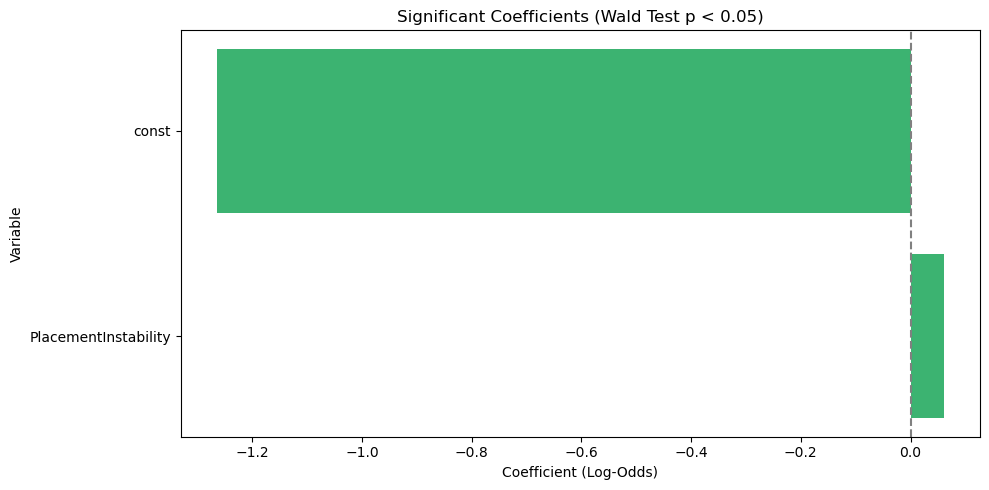

In [138]:

# Plot: Bar chart of significant coefficients
plt.figure(figsize=(10, 5))
plt.barh(model3_summary_sig['Variable'], model3_summary_sig['Coefficient'], color='mediumseagreen')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title("Significant Coefficients (Wald Test p < 0.05)")
plt.xlabel("Coefficient (Log-Odds)")
plt.ylabel("Variable")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The more placments there are, the more likely they will be homeless

# Model 4
How Placement effect Education & Job 

Dependent
* PostSecEd_or_FTE

Independent
* PlacementType 
* PlacementInstability
* MonthsInCare

In [139]:
# STEP 1: Check your variables
X_cols = ['PlacementType', 'PlacementInstability', 'MonthsInCare']
y_col = 'PostSecEd_or_FTE'

In [140]:
 # STEP 2: Select those columns
Model_4 = wave_service_afcars[X_cols + [y_col]].copy() # One-hot encode PlacementType if categorical

In [141]:
Model_4 = pd.get_dummies(Model_4, columns=['PlacementType'], drop_first=True) # One-hot encode PlacementType if categorical

In [142]:
# STEP 4: Drop missing or infinite
Model_4 = Model_4.replace([np.inf, -np.inf], np.nan).dropna()

In [143]:
# STEP 6: Separate X and y
X = sm.add_constant(Model_4.drop(columns=[y_col])).astype(float)
y = Model_4[y_col].astype(int)  # Must be binary (0/1) and numeric

In [144]:
# Step 5: VIF calculation
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Output
print("📊 Variance Inflation Factors Model 3:")
print(vif_data)

📊 Variance Inflation Factors Model 3:
                feature       VIF
0                 const  4.741404
1  PlacementInstability  1.658104
2          MonthsInCare  1.696234
3       PlacementType_2  1.295408
4       PlacementType_3  1.321793


In [145]:
# STEP 7: Fit logistic regression
Model4 = sm.Logit(y, X)
result4 = Model4.fit() # Output
print(result4.summary()) # Extract p-values

Optimization terminated successfully.
         Current function value: 0.594686
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:       PostSecEd_or_FTE   No. Observations:                  480
Model:                          Logit   Df Residuals:                      475
Method:                           MLE   Df Model:                            4
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:                 0.02927
Time:                        09:33:09   Log-Likelihood:                -285.45
converged:                       True   LL-Null:                       -294.06
Covariance Type:            nonrobust   LLR p-value:                  0.001755
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.9241      0.227      4.063      0.000       0.478       1.370

In [146]:
# Extract p-values
pvals = result4.pvalues

# Set alpha threshold
alpha = 0.05

# Filter to only significant variables
significant_vars = pvals[pvals < alpha]

# Create summary DataFrame for significant variables
Model4_summary_sig = pd.DataFrame({
    'Variable': significant_vars.index,
    'Coefficient': result4.params[significant_vars.index],
    'P-Value': significant_vars.values,
    'CI Lower': result4.conf_int().loc[significant_vars.index][0].values,
    'CI Upper': result4.conf_int().loc[significant_vars.index][1].values
}).reset_index(drop=True)

# Show only significant predictors
print(Model4_summary_sig)


               Variable  Coefficient   P-Value  CI Lower  CI Upper
0                 const     0.924066  0.000048  0.478335  1.369797
1  PlacementInstability    -0.072202  0.006741 -0.124433 -0.019971
2          MonthsInCare     0.024892  0.004338  0.007788  0.041997


In [147]:
Model4_summary_sig.to_csv('Model4_summary_sig.csv', index=False)

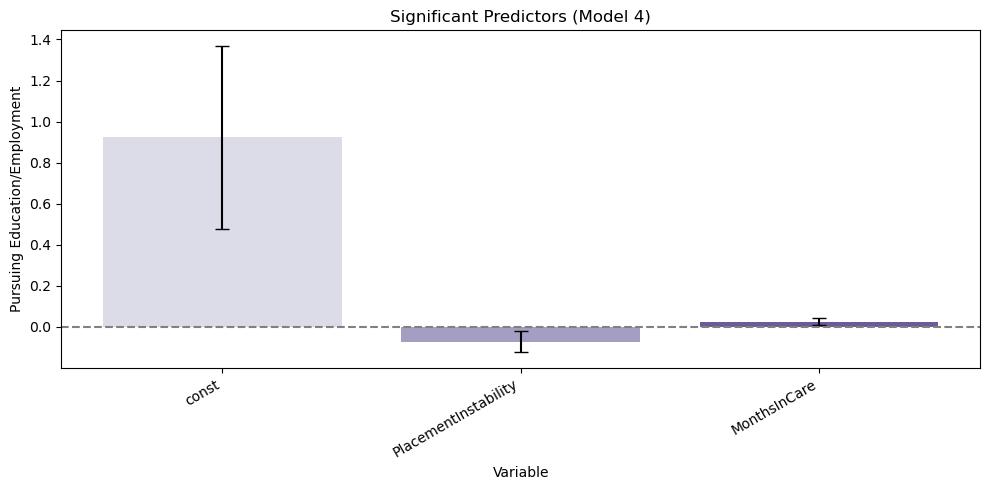

In [148]:

# Plot significant coefficients with 95% confidence intervals
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Variable',
    y='Coefficient',
    data=Model4_summary_sig,
    palette='Purples'
)
# Add error bars manually for 95% CI
for i, row in Model4_summary_sig.iterrows():
    plt.errorbar(
        x=i,
        y=row['Coefficient'],
        yerr=[[row['Coefficient'] - row['CI Lower']], [row['CI Upper'] - row['Coefficient']]],
        fmt='none',
        capsize=5,
        color='black'
    )
# Style plot
plt.axhline(0, color='gray', linestyle='--')
plt.title('Significant Predictors (Model 4)')
plt.ylabel('Pursuing Education/Employment')
plt.xlabel('Variable')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

* Unstable placement make's individuals less likely to get a full time job or pursue higher education (p =  0.006741)
* The more time them spend in fostercare, the more likely they are to get a job/education (p = 0.004338)

# Model 5
How Placement effects Substance Abuse
Independent 
* PlacementType 
* PlacementInstability
* MonthsInCare

Dependent 
* SubAbuse_w1

In [149]:
# STEP 1: Check your variables
X_cols = ['PlacementType', 'PlacementInstability', 'MonthsInCare']
y_col = 'SubAbuse_w1'

In [150]:
 # STEP 2: Select those columns
Model_5 = wave_service_afcars[X_cols + [y_col]].copy() # One-hot encode PlacementType if categorical

In [151]:
Model_5 = pd.get_dummies(Model_5, columns=['PlacementType'], drop_first=True) # One-hot encode PlacementType if categorical

In [152]:

Model_5 = Model_5.replace([np.inf, -np.inf], np.nan).dropna() # STEP 6: Separate X and y

In [153]:
# STEP 6: Separate X and y
X = sm.add_constant(Model_5.drop(columns=[y_col])).astype(float)
y = pd.to_numeric(Model_5[y_col], errors='coerce').astype(int)

In [154]:
# Step 5: VIF calculation
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Output
print("📊 Variance Inflation Factors Model 3:")
print(vif_data)

📊 Variance Inflation Factors Model 3:
                feature       VIF
0                 const  4.736026
1  PlacementInstability  1.644132
2          MonthsInCare  1.687693
3       PlacementType_2  1.288600
4       PlacementType_3  1.319309


In [155]:
model5 = sm.Logit(y, X)
result5 = model5.fit() # Output
print(result5.summary()) # Extract p-values
pvals = result5.pvalues

Optimization terminated successfully.
         Current function value: 0.601468
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            SubAbuse_w1   No. Observations:                  478
Model:                          Logit   Df Residuals:                      473
Method:                           MLE   Df Model:                            4
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:                 0.05434
Time:                        09:33:09   Log-Likelihood:                -287.50
converged:                       True   LL-Null:                       -304.02
Covariance Type:            nonrobust   LLR p-value:                 1.171e-06
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.0758      0.227     -4.730      0.000      -1.522      -0.630

In [156]:
# Set alpha threshold
alpha = 0.05

# Filter to only significant variables
significant_vars = pvals[pvals < alpha]

# Create summary DataFrame for significant variables
model5_summary_sig = pd.DataFrame({
    'Variable': significant_vars.index,
    'Coefficient': result5.params[significant_vars.index],
    'P-Value': significant_vars.values,
    'CI Lower': result5.conf_int().loc[significant_vars.index][0].values,
    'CI Upper': result5.conf_int().loc[significant_vars.index][1].values
}).reset_index(drop=True)


In [157]:
# Show only significant predictors
print(model5_summary_sig)

               Variable  Coefficient   P-Value  CI Lower  CI Upper
0                 const    -1.075788  0.000002 -1.521592 -0.629983
1  PlacementInstability     0.100885  0.000191  0.047886  0.153885
2          MonthsInCare    -0.025552  0.002712 -0.042253 -0.008850
3       PlacementType_2     0.766881  0.004972  0.231767  1.301994


In [158]:
model5_summary_sig.to_csv('Model5_summary_sig.csv', index=False)

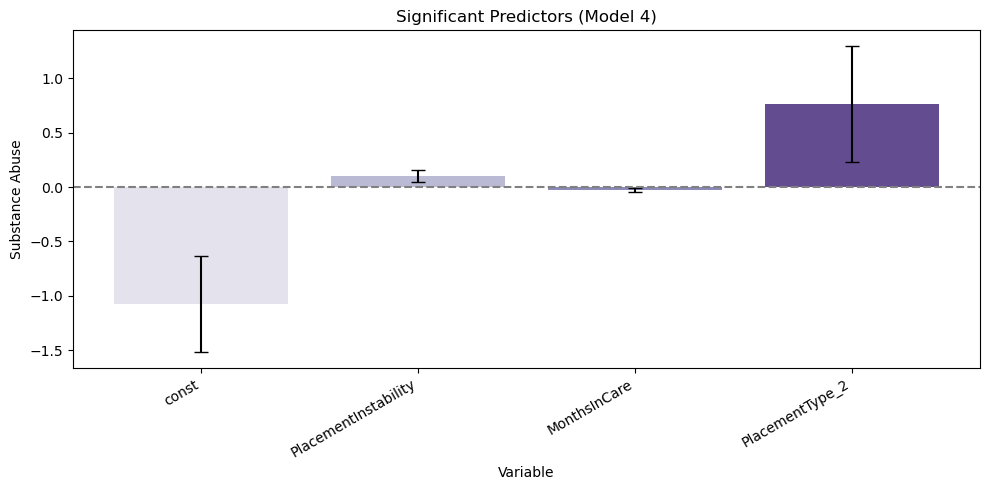

In [159]:
# Plot significant coefficients with 95% confidence intervals
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Variable',
    y='Coefficient',
    data=model5_summary_sig,
    palette='Purples'
)
# Add error bars manually for 95% CI
for i, row in model5_summary_sig.iterrows():
    plt.errorbar(
        x=i,
        y=row['Coefficient'],
        yerr=[[row['Coefficient'] - row['CI Lower']], [row['CI Upper'] - row['Coefficient']]],
        fmt='none',
        capsize=5,
        color='black'
    )
# Style plot
plt.axhline(0, color='gray', linestyle='--')
plt.title('Significant Predictors (Model 4)')
plt.ylabel('Substance Abuse')
plt.xlabel('Variable')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

* If they have unstable housing they are more likely to have substance abuse referals [ p 0.000191]
* If they have more time in care they are SLIGHTLY less likely to be referd for substane abuse [p =  0.002712]
* If they are in Foster family home, relative (PlacementType_2 ) they are very likely to be refered for substance abuse [p = 0.004972]

# Model 6
How Placement effects Incarceration 
Independent 
* PlacementType 
* PlacementInstability
* MonthsInCare

Dependent 
* Incarc_w23

In [160]:
# STEP 1: Check your variables
X_cols = ['PlacementType', 'PlacementInstability', 'MonthsInCare']
y_col = 'Incarc_w23' 

In [161]:
 # STEP 2: Select those columns
Model_6 = wave_service_afcars[X_cols + [y_col]].copy() # One-hot encode PlacementType if categorical

In [162]:
 # STEP 2: Select those columns
Model_6 = pd.get_dummies(Model_6, columns=['PlacementType'], drop_first=True) # One-hot encode PlacementType if categorical

In [163]:
 # STEP : Drop missing or infinite
Model_6 = Model_6.replace([np.inf, -np.inf], np.nan).dropna()

In [164]:
# STEP 6: Separate X and y
X = sm.add_constant(Model_6.drop(columns=[y_col])).astype(float)
y = pd.to_numeric(Model_6[y_col], errors='coerce').astype(int)

In [165]:
# Step 5: VIF calculation
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Output
print("📊 Variance Inflation Factors Model 3:")
print(vif_data)

📊 Variance Inflation Factors Model 3:
                feature       VIF
0                 const  4.732836
1  PlacementInstability  1.658132
2          MonthsInCare  1.695464
3       PlacementType_2  1.293350
4       PlacementType_3  1.320098


In [166]:
 # STEP 7: Fit logistic regression
model6 = sm.Logit(y, X)
result6 = model6.fit() # Output
print(result6.summary()) # Extract p-values

Optimization terminated successfully.
         Current function value: 0.550110
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Incarc_w23   No. Observations:                  479
Model:                          Logit   Df Residuals:                      474
Method:                           MLE   Df Model:                            4
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:                  0.1173
Time:                        09:33:10   Log-Likelihood:                -263.50
converged:                       True   LL-Null:                       -298.53
Covariance Type:            nonrobust   LLR p-value:                 2.217e-14
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.5386      0.259     -5.932      0.000      -2.047      -1.030

In [167]:
pvals = result6.pvalues

# Set alpha threshold
alpha = 0.05

# Filter to only significant variables
significant_vars = pvals[pvals < alpha]

# Create summary DataFrame for significant variables
model6_summary_sig = pd.DataFrame({
    'Variable': significant_vars.index,
    'Coefficient': result6.params[significant_vars.index],
    'P-Value': significant_vars.values,
    'CI Lower': result6.conf_int().loc[significant_vars.index][0].values,
    'CI Upper': result6.conf_int().loc[significant_vars.index][1].values
}).reset_index(drop=True)

# Show only significant predictors
print(model6_summary_sig)

               Variable  Coefficient       P-Value  CI Lower  CI Upper
0                 const    -1.538650  2.991531e-09 -2.047022 -1.030277
1  PlacementInstability     0.107191  1.498279e-04  0.051778  0.162603
2          MonthsInCare    -0.035012  2.448381e-04 -0.053722 -0.016301
3       PlacementType_2     1.411860  2.108361e-06  0.828402  1.995318
4       PlacementType_3     1.233799  3.490835e-06  0.712590  1.755008


In [168]:
model6_summary_sig.to_csv('model6_summary_sig.csv', index=False)

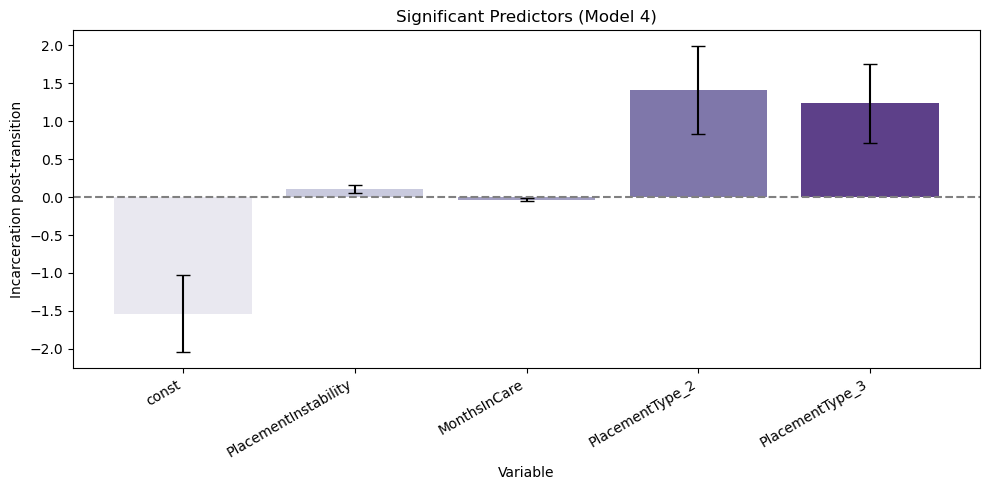

In [169]:
# Plot significant coefficients with 95% confidence intervals
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Variable',
    y='Coefficient',
    data=model6_summary_sig,
    palette='Purples'
)
# Add error bars manually for 95% CI
for i, row in model6_summary_sig.iterrows():
    plt.errorbar(
        x=i,
        y=row['Coefficient'],
        yerr=[[row['Coefficient'] - row['CI Lower']], [row['CI Upper'] - row['Coefficient']]],
        fmt='none',
        capsize=5,
        color='black'
    )
# Style plot
plt.axhline(0, color='gray', linestyle='--')
plt.title('Significant Predictors (Model 4)')
plt.ylabel('Incarceration post-transition')
plt.xlabel('Variable')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

* If they have placment instability they are more likely to be incarcerated post transition (p =  1.498279e-04)
* If they are places in a relative Foster Family Home (PlacementType_2) they are MUCH more likely to be incarcerated (p = 2.108361e-06)
* If they are placed in a non relative foster family home (PlacementType_3), they are most likely to be incarerated (p = 3.490835e-06)

# Model Ideas 1: 

1. early risk factors for homelessness post-transition
* Dependent: Homeless_w23
* Independent: PlacementInstability, MonthsInCare, NEGLECT, SubAbuse_w1
* Controls: Sex, RaceEthn

2. connection to caring adults/education services supports post-secondary attainment
* Dependent: higher_education_columns
* Independent:  CnctAdult_w1, CurrFTE_w1, PlacementType,  EducAid_w1
* Control: RaceEthn, Sex

3. Identifies risk of justice involvement
* Dependent:  Incarc_w23
* Independent: removal_reason_columns, SubAbuse_w1 PlacementInstability, EmplySklls_w1
* Controls: Sex, RaceEthn

4. Offers a holistic measure of post-foster care success
* Dependent:  no homelessness, no incarceration, has education/employment
* Independent: Service_Count , EmplySklls_w1, PlacementType
* Controls: RaceEthn, Sex

5. Identifies whether disabilities and supports influence educational access.
* Dependent: higher_education_columns
* Independent: CLINDIS, DiagDis, Service_Count, EducAid_w1
* Controls: RaceEthn, Sex, PlacementType

6. Tests whether longer foster care is protective or destabilizing for long-term housing.
* Dependent: Homeless_w23
* Independent: MonthsInCare, PlacementInstability, PlacementType, removal_reason_columns
* Controls: RaceEthn, Sex


# Idea Models 2


1. Predicting Late Homelessne
* Dependent: Homeless_w23
* Independent: Homeless_w1 (early homelessness history), PlacementInstability, RR_neglect, RR_abuse, RR_other, MonthsInCare
* Controls: Sex, race_ethnicity_columns, DiagDis

2. Educational Attainment by Wave 3
* Dependent: higher_education_columns
* Independent: Service_Count, PlacementType, DiagDis, SubAbuse_w1
* Controls: Sex, race_ethnicity_columns, Homeless_w1, MonthsInCare

3. Placement Instability Risk
* Dependent: PlacementInstability
* Independent: RR_abuse, RR_neglect, DiagDis, SubAbuse_w1, Service_Count
* Controls: Sex, race_ethnicity_columns, MonthsInCare

4. Impact of Disability on Life Outcomes
* Dependent: NO higher_education_columns OR Employment
* Independent:DiagDis, PlacementInstability, Homeless_w1
* Controls: Sex, race_ethnicity_columns, Service_Count, RR_other

5. Early Predictors of Disconnection
* Dependent: NO higher_education_columns OR Employment
* Independent: Homeless_w1, Incarc_w1, SubAbuse_w1, Service_Count
* Controls: Sex, race_ethnicity_columns, DiagDis

6. Length in Care and Long-Term Stability
* Dependent: no Homeless_w23 or has CurrFTE_w23 
* Independent: MonthsInCare, PlacementType,PlacementInstability
* Controls: Sex, race_ethnicity_columns, RR_neglect, Service_Count

# Multi model

In [170]:
wave_service_afcars['Children_w23'] = pd.to_numeric(wave_service_afcars['Children_w23'], errors='coerce').astype('Int64')
wave_service_afcars['Marriage_w23'] = pd.to_numeric(wave_service_afcars['Marriage_w23'], errors='coerce').astype('Int64')


In [171]:
wave_service_afcars['Children_NoMarriage_w23'] = (
    (wave_service_afcars['Children_w23'] == 1) & 
    (wave_service_afcars['Marriage_w23'] == 0)
).astype('Int64')



In [172]:
wave_service_afcars['AI_AN_Only'] = pd.to_numeric(wave_service_afcars['AI_AN_Only'], errors='coerce').astype('Int64')
wave_service_afcars['Asian_Only'] = pd.to_numeric(wave_service_afcars['Asian_Only'], errors='coerce').astype('Int64')
wave_service_afcars['PacIsl_Only'] = pd.to_numeric(wave_service_afcars['PacIsl_Only'], errors='coerce').astype('Int64')
wave_service_afcars['Multi_Race'] = pd.to_numeric(wave_service_afcars['Multi_Race'], errors='coerce').astype('Int64')

In [173]:
wave_service_afcars['race_other'] = (
    (wave_service_afcars[['AI_AN_Only', 'Asian_Only', 'PacIsl_Only', 'Multi_Race']] == 1)
    .any(axis=1)
).astype(int)

In [174]:
wave_service_afcars['CurrFTE_w23'] = pd.to_numeric(wave_service_afcars['CurrFTE_w23'], errors='coerce').astype('Int64')
wave_service_afcars['CurrenRoll_w23'] = pd.to_numeric(wave_service_afcars['CurrenRoll_w23'], errors='coerce').astype('Int64')

In [175]:
wave_service_afcars['Connected_Youth'] = (
    (wave_service_afcars['CurrFTE_w23'] == 1) | 
    (wave_service_afcars['CurrenRoll_w23'] == 1)
).astype('Int64')

In [186]:
wave_service_afcars.to_csv("wave_service_afcars_final.csv", index=False)

In [176]:
outcomes = [
    'Connected_Youth',
    'CnctAdult_w23',
    'Homeless_w23',
    'SubAbuse_w23',
    'Incarc_w23',
    'Children_NoMarriage_w23'

]

predictor_groups = {
    'Core': ['Sex'] + ['White_Only', 'race_other'],
    'Disability': ['DiagDis'],
    'RemovalReason': ['RR_neglect', 'RR_abuse', 'RR_other'],
    'Placement': ['PlacementType', 'PlacementInstability', 'MonthsInCare'],
    'EarlyIndicators': ['SubAbuse_w1', 'CnctAdult_w1']
}


In [177]:
all_results = []
significant_results = []

for outcome in outcomes:
    predictors = sum(predictor_groups.values(), [])  # flatten all predictor lists
    model_vars = predictors + [outcome]
    
    df_model = wave_service_afcars[model_vars].copy()
    df_model = df_model.replace([np.inf, -np.inf], np.nan).dropna()
    df_model = df_model.apply(pd.to_numeric, errors='coerce')

    # Only one-hot encode PlacementType (Race already handled via binary flags)
    df_model = pd.get_dummies(df_model, columns=['PlacementType'], drop_first=True)

    # Prepare X and y
    y = df_model[outcome].astype(int)
    X = df_model.drop(columns=[outcome])
    X = sm.add_constant(X)

    try:
        # Fit logistic regression
        model = sm.Logit(y, X)
        result = model.fit(disp=False)
        
        # Extract full summary
        pvals = result.pvalues
        summary_df = pd.DataFrame({
            'Outcome': outcome,
            'Variable': pvals.index,
            'Coefficient': result.params,
            'P-Value': pvals,
            'CI Lower': result.conf_int()[0],
            'CI Upper': result.conf_int()[1]
        })

        # Mark significance
        summary_df['Significant'] = summary_df['P-Value'] < 0.05
        all_results.append(summary_df)

        # Store only significant rows
        sig_only = summary_df[summary_df['Significant'] == True]
        significant_results.append(sig_only)

        print(f"✅ Model completed for outcome: {outcome}")

    except Exception as e:
        print(f"❌ Model failed for outcome: {outcome} — {e}")


✅ Model completed for outcome: Connected_Youth
✅ Model completed for outcome: CnctAdult_w23
✅ Model completed for outcome: Homeless_w23
✅ Model completed for outcome: SubAbuse_w23
✅ Model completed for outcome: Incarc_w23
✅ Model completed for outcome: Children_NoMarriage_w23


In [178]:
# Combine results across all models
all_results_df = pd.concat(all_results, ignore_index=True)



# Show top significant results
print("📊 Top Significant Predictors (p < 0.05):")
display(all_results_df.head(10))



📊 Top Significant Predictors (p < 0.05):


,Outcome,Variable,Coefficient,P-Value,CI Lower,CI Upper,Significant
0,Connected_Youth,const,0.728889,0.341902,-0.774243,2.232021,False
1,Connected_Youth,Sex,0.518052,0.022106,0.074381,0.961723,True
2,Connected_Youth,White_Only,-0.027921,0.903517,-0.479367,0.423525,False
3,Connected_Youth,race_other,0.355022,0.570241,-0.870686,1.580729,False
4,Connected_Youth,DiagDis,-0.489774,0.022817,-0.911449,-0.068099,True
5,Connected_Youth,RR_neglect,0.120138,0.719546,-0.535636,0.775913,False
6,Connected_Youth,RR_abuse,0.238614,0.599982,-0.653168,1.130395,False
7,Connected_Youth,RR_other,-0.185765,0.681949,-1.074219,0.702689,False
8,Connected_Youth,PlacementInstability,-0.073317,0.008234,-0.127700,-0.018933,True
9,Connected_Youth,MonthsInCare,0.018982,0.031192,0.001715,0.036249,True


In [179]:
print(all_results_df.shape)


(84, 7)


In [180]:
significant_results_df = pd.concat(significant_results, ignore_index=True)

In [181]:
# Sort for readability (optional)
significant_results_df = significant_results_df.sort_values(by=['Outcome', 'P-Value'])


In [182]:
significant_results_df.head()

,Outcome,Variable,Coefficient,P-Value,CI Lower,CI Upper,Significant
17,Children_NoMarriage_w23,const,-2.621146,0.009597,-4.604654,-0.637639,True
18,Children_NoMarriage_w23,White_Only,-0.542520,0.026784,-1.022650,-0.062391,True
5,CnctAdult_w23,CnctAdult_w1,1.335801,0.032398,0.112072,2.559529,True
4,CnctAdult_w23,const,2.972662,0.032921,0.241210,5.704114,True
2,Connected_Youth,PlacementInstability,-0.073317,0.008234,-0.127700,-0.018933,True


In [183]:
print(significant_results_df.shape)


(19, 7)


In [184]:
# Save to CSV (optional)
all_results_df.to_csv("all_model_results.csv", index=False)
significant_results_df.to_csv("significant_model_results.csv", index=False)


In [189]:
significant_model_results = significant_results_df

# Visual

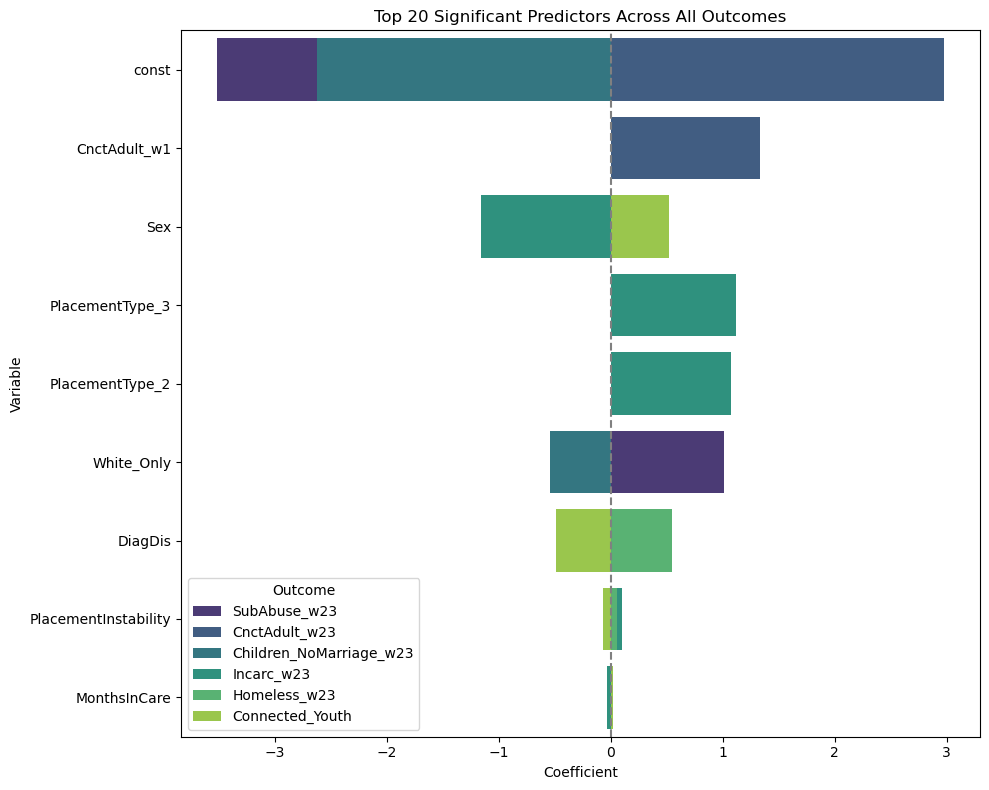

In [190]:
# Select top 20 by absolute coefficient size
top_sig = significant_model_results.copy()
top_sig['abs_coef'] = top_sig['Coefficient'].abs()
top_20 = top_sig.sort_values(by='abs_coef', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_20,
    y='Variable',
    x='Coefficient',
    hue='Outcome',
    dodge=False,
    palette='viridis'
)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Top 20 Significant Predictors Across All Outcomes")
plt.tight_layout()
plt.show()


# Modeling of Significant

In [187]:
# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [191]:
# Cell 2: Load and examine the significant results data
print("Significant Model Results Overview:")
print(f"Total significant effects: {len(significant_model_results)}")
print(f"Unique outcomes: {significant_model_results['Outcome'].nunique()}")
print(f"Outcomes: {significant_model_results['Outcome'].unique()}")
print(f"\nP-value range: {significant_model_results['P-Value'].min():.6f} to {significant_model_results['P-Value'].max():.6f}")
print(f"Coefficient range: {significant_model_results['Coefficient'].min():.3f} to {significant_model_results['Coefficient'].max():.3f}")


Significant Model Results Overview:
Total significant effects: 19
Unique outcomes: 6
Outcomes: ['Children_NoMarriage_w23' 'CnctAdult_w23' 'Connected_Youth'
 'Homeless_w23' 'Incarc_w23' 'SubAbuse_w23']

P-value range: 0.000004 to 0.043271
Coefficient range: -3.516 to 2.973


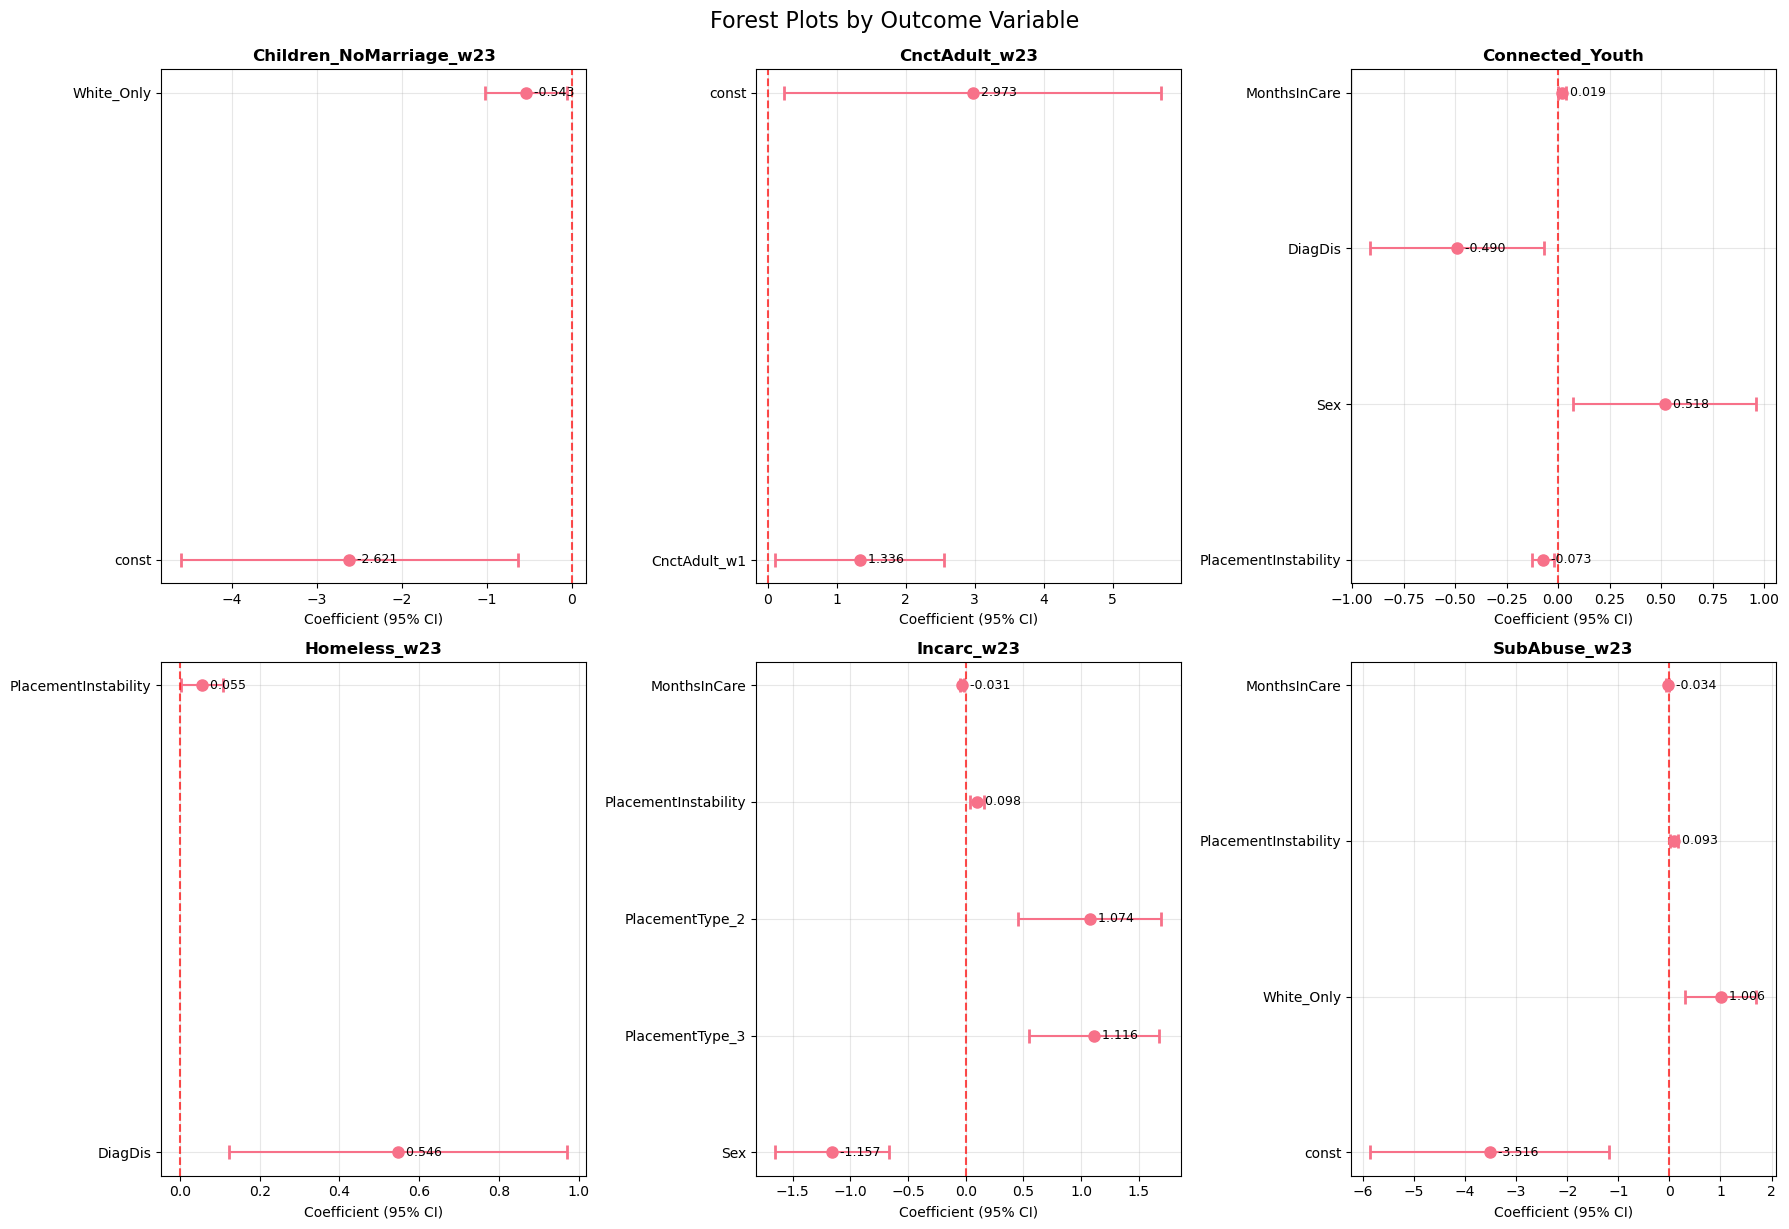

In [192]:
# Cell 3: Forest Plot by Outcome
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

outcomes = significant_model_results['Outcome'].unique()
for i, outcome in enumerate(outcomes):
    if i < len(axes):
        outcome_data = significant_model_results[significant_model_results['Outcome'] == outcome]
        
        y_pos = range(len(outcome_data))
        coeffs = outcome_data['Coefficient']
        ci_lower = outcome_data['CI Lower']
        ci_upper = outcome_data['CI Upper']
        
        # Create error bars
        axes[i].errorbar(coeffs, y_pos,
                        xerr=[coeffs - ci_lower, ci_upper - coeffs],
                        fmt='o', capsize=5, capthick=2, markersize=8)
        
        axes[i].set_yticks(y_pos)
        axes[i].set_yticklabels(outcome_data['Variable'], fontsize=10)
        axes[i].set_xlabel('Coefficient (95% CI)')
        axes[i].set_title(f'{outcome}', fontsize=12, fontweight='bold')
        axes[i].axvline(x=0, color='red', linestyle='--', alpha=0.7)
        axes[i].grid(True, alpha=0.3)
        
        # Add coefficient values as text
        for j, (coef, var) in enumerate(zip(coeffs, outcome_data['Variable'])):
            axes[i].text(coef, j, f'  {coef:.3f}', va='center', fontsize=9)

# Hide empty subplots
for i in range(len(outcomes), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Forest Plots by Outcome Variable', fontsize=16, y=1.02)
plt.show()

# ### Visual Above:
# * Forest Plot: shows significant predictors for 6 outcomes
# **Top Left: Children without being married in wave 2/3**
# * **White_Only**: White youth are LESS likely (-0.543) to have children without being married
# * Larger negative intercept (-2.621) means there is a low probability of the outcome
#
# **Top Center: Connected adult in wave 2/3**
# * **Connected Adult in wave 1**: Having a strongly connected adult strongly predicts future outcomes (1.336)
# * **Constant**: There is a high baseline of adult connections (2.973)
#
# **Top Right: Connected Youth (pursuing a full-time job or higher education post-transition)**
# * **Months in care**: The longer the care duration, the more likely they are to have increased youth connections (0.019)
# * **Diagnosed with a disability**: Youth with a disability are less likely (-0.490) to be connected youth
# * **Sex**: One gender is more likely (0.518) to be connected
# * **PlacementInstability**: The more unstable the placement, the less likely they will be connected youth (-0.073)
#
# **Bottom Left: Homeless post-transition**
# * **PlacementInstability**: Unstable placement increases risk of homelessness (0.055)
# * **Diagnosed Disability**: A disability significantly increases risk of homelessness (0.546)
#
# **Bottom Center: Incarceration post-transition**
# * **Sex**: Large gender difference in incarceration (-1.157)
# * **Months in care**: Longer time in care reduces incarceration (-0.031)
# * **PlacementInstability**: Unstable placement increases incarceration (0.098)
# * **Placement_Type_2**: Individuals in group homes are more likely to be incarcerated (1.074)
# * **Placement_Type_3**: Individuals in type 3 homes are more likely to be incarcerated (1.116)
#
# **Bottom Right: Substance abuse post-transition**
# * **White_Only**: White youth are more likely (1.006) to have substance abuse
# * **Months in care**: Longer time in care reduces substance abuse (-0.034)
# * **PlacementInstability**: More moves increase substance abuse (0.093)
* **Constant**: Overall low baseline probability (-3.516)

In [ ]:
wave_service_afcars = pd.read_csv('nytd_final_modeling_data_20250724_090259(in).csv', dtype=str)

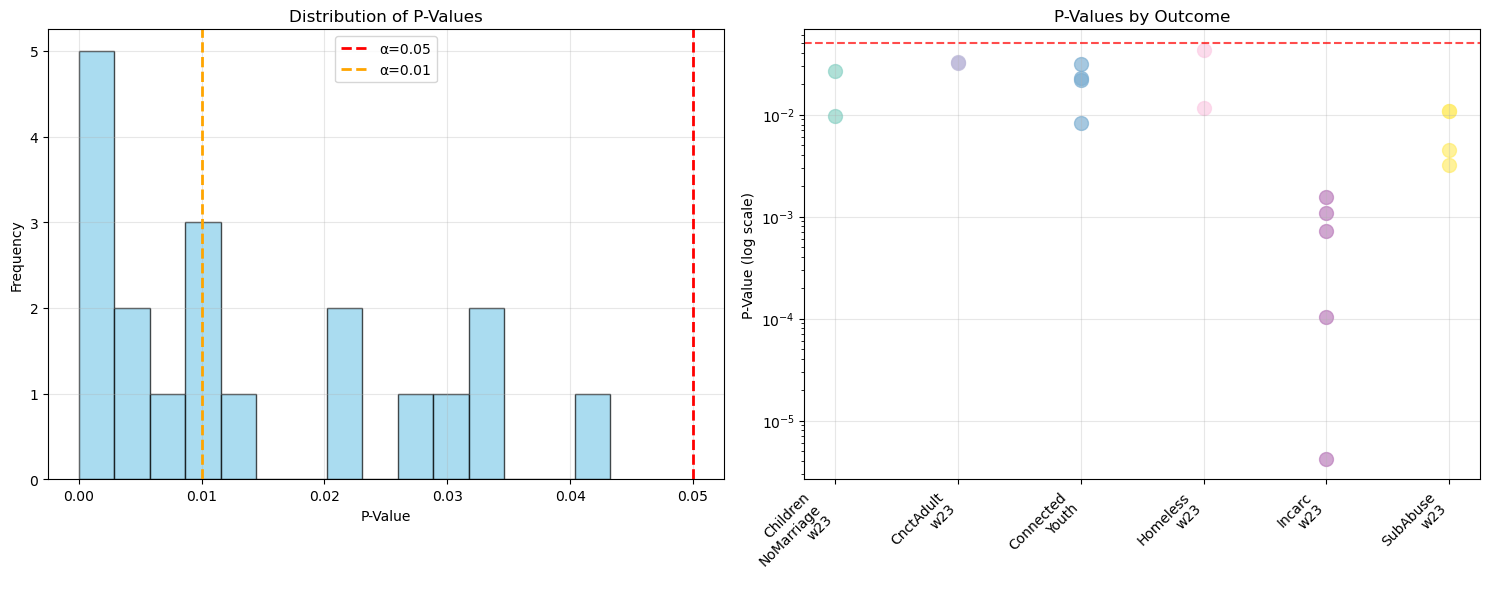

In [193]:
# Cell 4: P-Value Distribution and Significance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# P-value histogram
ax1.hist(significant_model_results['P-Value'], bins=15, alpha=0.7, edgecolor='black', color='skyblue')
ax1.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α=0.05')
ax1.axvline(x=0.01, color='orange', linestyle='--', linewidth=2, label='α=0.01')
ax1.set_xlabel('P-Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of P-Values')
ax1.legend()
ax1.grid(True, alpha=0.3)

# P-value by outcome
outcomes_for_plot = significant_model_results['Outcome'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(outcomes_for_plot)))

for i, outcome in enumerate(outcomes_for_plot):
    outcome_data = significant_model_results[significant_model_results['Outcome'] == outcome]
    ax2.scatter([i] * len(outcome_data), outcome_data['P-Value'], 
               alpha=0.7, s=100, color=colors[i], label=outcome)

ax2.set_yscale('log')
ax2.set_xticks(range(len(outcomes_for_plot)))
ax2.set_xticklabels([outcome.replace('_', '\n') for outcome in outcomes_for_plot], rotation=45, ha='right')
ax2.set_ylabel('P-Value (log scale)')
ax2.set_title('P-Values by Outcome')
ax2.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α=0.05')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

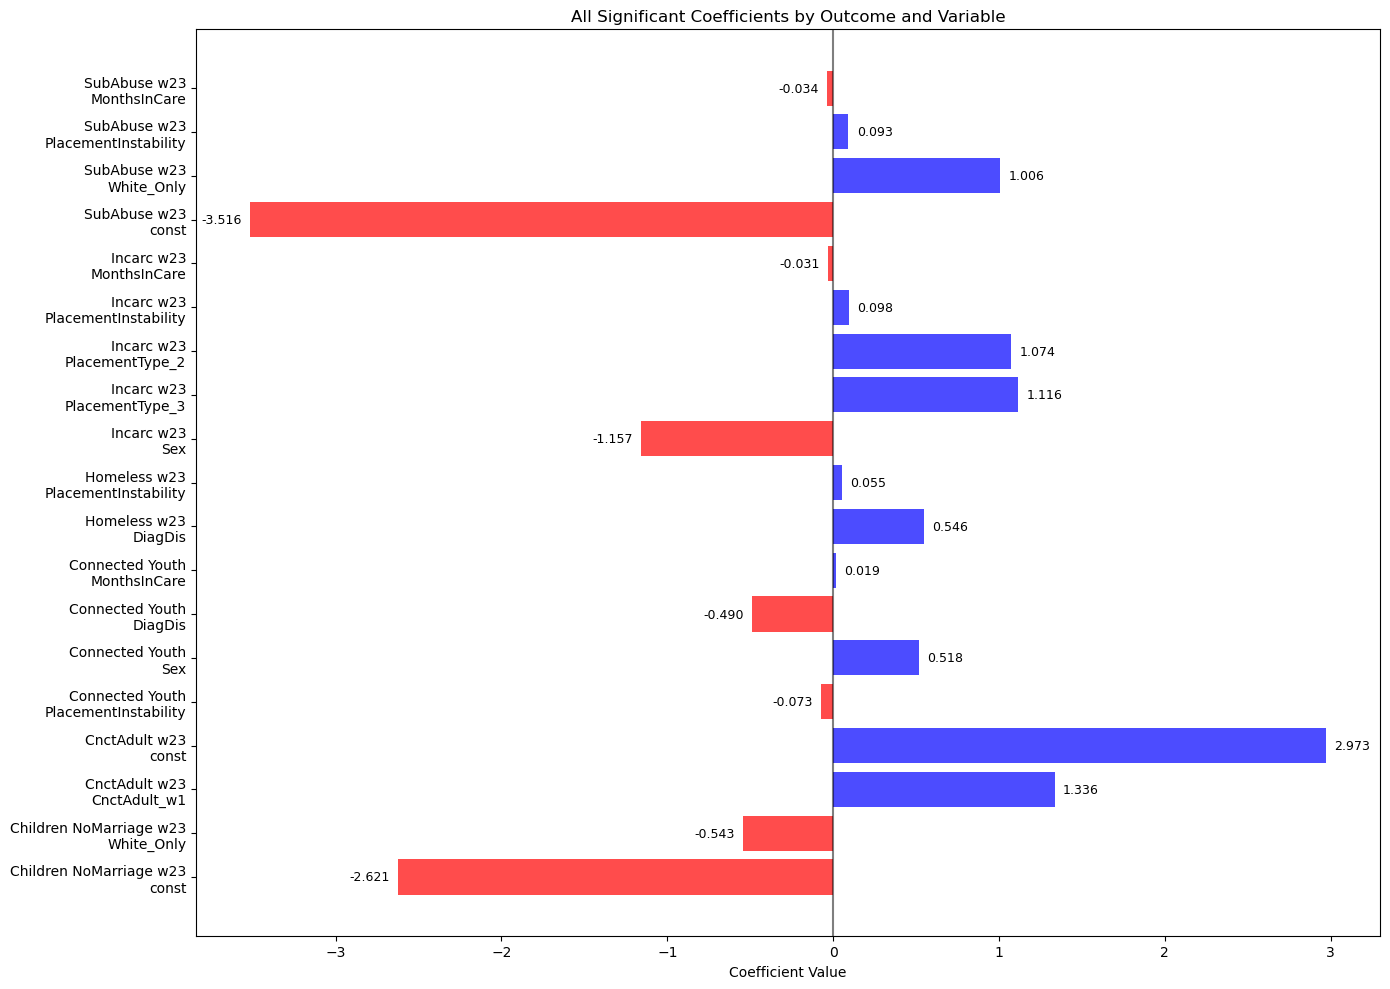

In [194]:
# Cell 5: Coefficient Magnitude Analysis
plt.figure(figsize=(14, 10))

# Create horizontal bar plot of all coefficients
y_pos = range(len(significant_model_results))
colors = ['red' if x < 0 else 'blue' for x in significant_model_results['Coefficient']]

plt.barh(y_pos, significant_model_results['Coefficient'], color=colors, alpha=0.7)

# Create labels with outcome and variable
labels = [f"{row['Outcome'].replace('_', ' ')}\n{row['Variable']}" 
          for _, row in significant_model_results.iterrows()]

plt.yticks(y_pos, labels, fontsize=10)
plt.xlabel('Coefficient Value')
plt.title('All Significant Coefficients by Outcome and Variable')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# Add coefficient values on bars
for i, (coef, outcome) in enumerate(zip(significant_model_results['Coefficient'], 
                                       significant_model_results['Outcome'])):
    offset = 0.05 if coef >= 0 else -0.05
    ha = 'left' if coef >= 0 else 'right'
    plt.text(coef + offset, i, f'{coef:.3f}', va='center', ha=ha, fontsize=9)

plt.tight_layout()
plt.show()

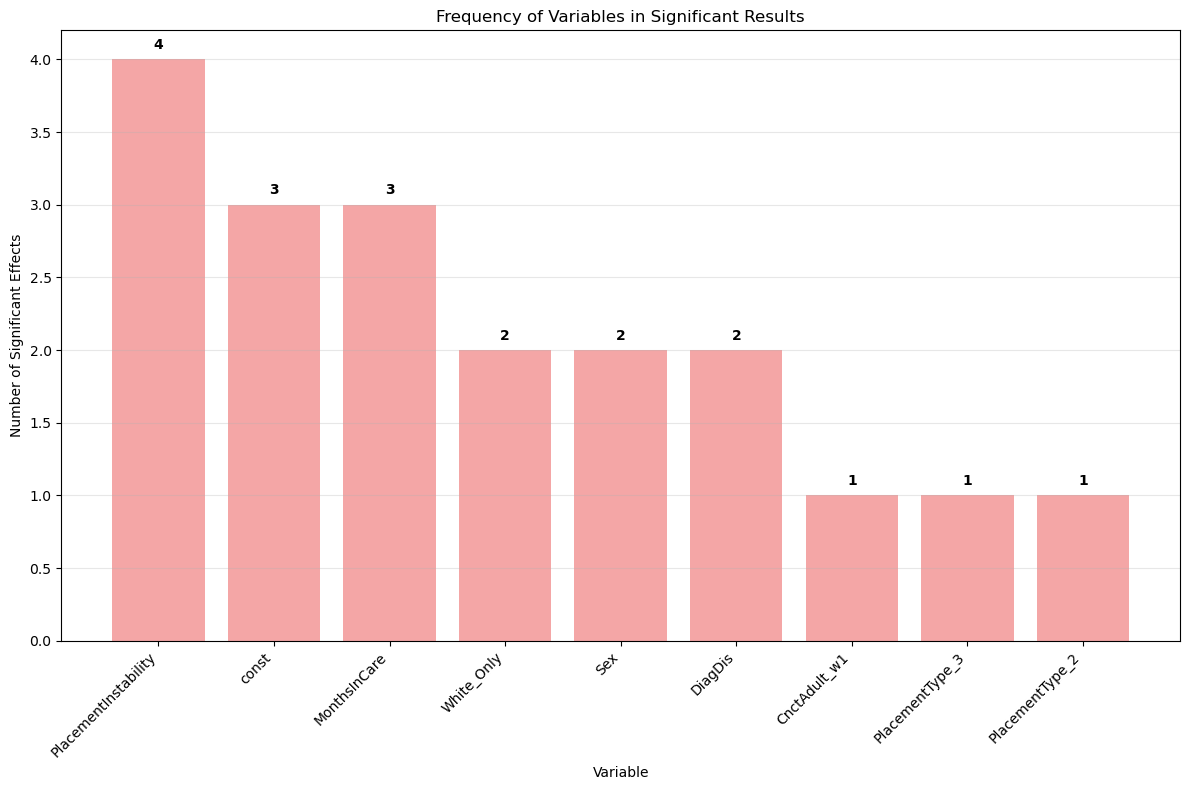

In [195]:
# Cell 6: Variable Frequency Analysis
plt.figure(figsize=(12, 8))

# Count how often each variable appears as significant
variable_counts = significant_model_results['Variable'].value_counts()

plt.bar(range(len(variable_counts)), variable_counts.values, alpha=0.7, color='lightcoral')
plt.xticks(range(len(variable_counts)), variable_counts.index, rotation=45, ha='right')
plt.ylabel('Number of Significant Effects')
plt.xlabel('Variable')
plt.title('Frequency of Variables in Significant Results')
plt.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, count in enumerate(variable_counts.values):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

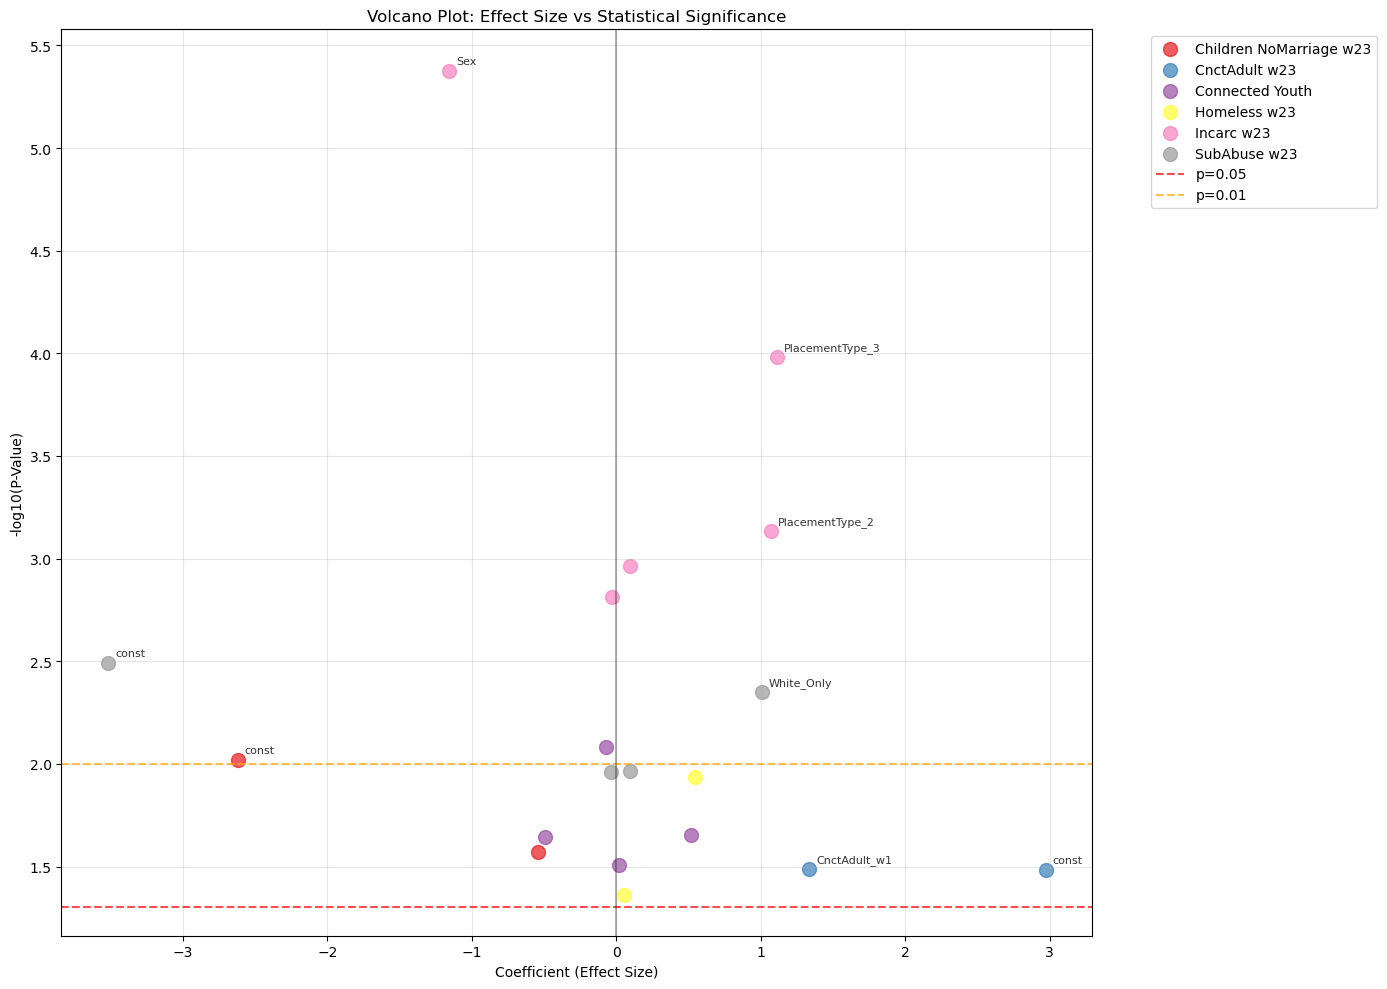

In [196]:
# Cell 7: Volcano Plot - Effect Size vs Significance
plt.figure(figsize=(14, 10))

# Create volcano plot
x = significant_model_results['Coefficient']
y = -np.log10(significant_model_results['P-Value'])

# Color by outcome
outcomes = significant_model_results['Outcome'].unique()
colors = plt.cm.Set1(np.linspace(0, 1, len(outcomes)))
color_map = dict(zip(outcomes, colors))

for outcome in outcomes:
    mask = significant_model_results['Outcome'] == outcome
    plt.scatter(x[mask], y[mask], 
               label=outcome.replace('_', ' '), 
               alpha=0.7, s=100, 
               color=color_map[outcome])

plt.xlabel('Coefficient (Effect Size)')
plt.ylabel('-log10(P-Value)')
plt.title('Volcano Plot: Effect Size vs Statistical Significance')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p=0.05')
plt.axhline(y=-np.log10(0.01), color='orange', linestyle='--', alpha=0.7, label='p=0.01')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add labels for extreme points
for _, row in significant_model_results.iterrows():
    if abs(row['Coefficient']) > 1 or row['P-Value'] < 0.001:
        plt.annotate(f"{row['Variable']}", 
                    (row['Coefficient'], -np.log10(row['P-Value'])),
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, alpha=0.8)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

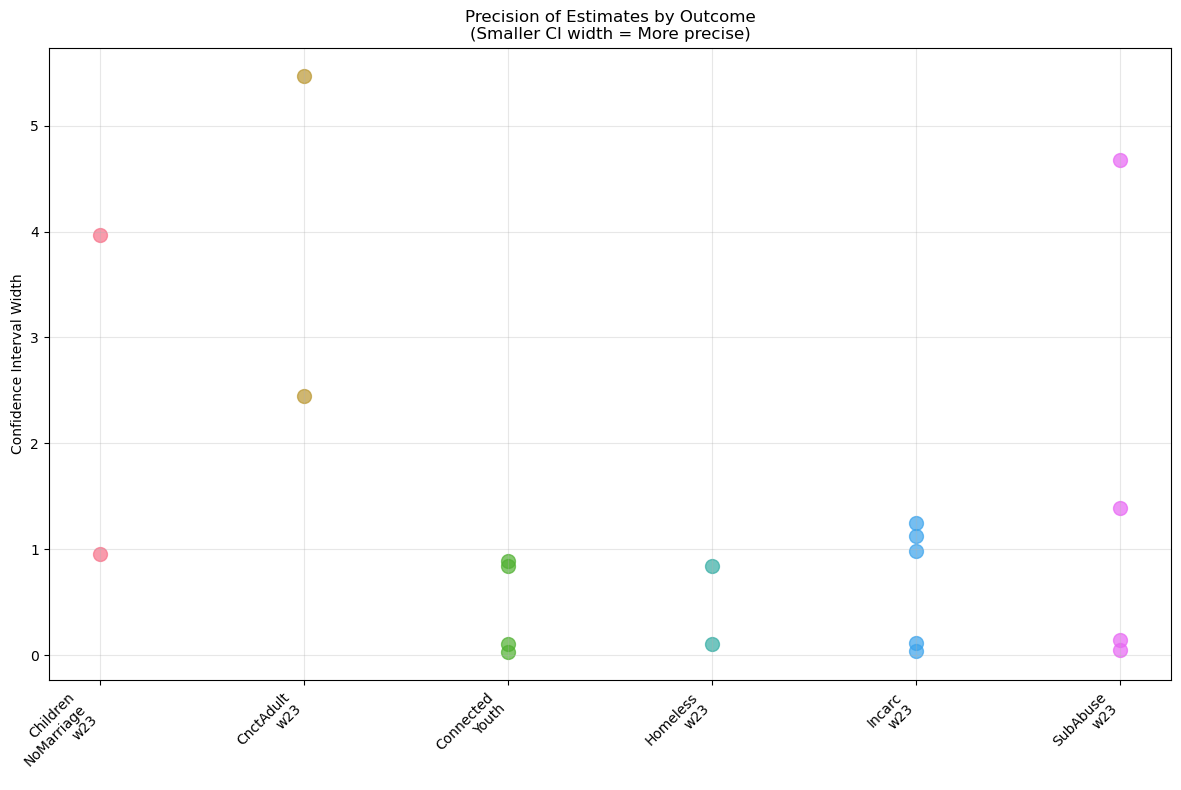

In [197]:
# Cell 8: Confidence Interval Width Analysis
plt.figure(figsize=(12, 8))

# Calculate CI width
significant_model_results['CI_Width'] = (significant_model_results['CI Upper'] - 
                                        significant_model_results['CI Lower'])

# Plot CI width by outcome
outcomes = significant_model_results['Outcome'].unique()
for i, outcome in enumerate(outcomes):
    outcome_data = significant_model_results[significant_model_results['Outcome'] == outcome]
    plt.scatter([i] * len(outcome_data), outcome_data['CI_Width'], 
               alpha=0.7, s=100, label=outcome)

plt.xticks(range(len(outcomes)), [outcome.replace('_', '\n') for outcome in outcomes], 
           rotation=45, ha='right')
plt.ylabel('Confidence Interval Width')
plt.title('Precision of Estimates by Outcome\n(Smaller CI width = More precise)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Variables to explore from main dataset: ['White_Only', 'CnctAdult_w1', 'PlacementInstability', 'Sex', 'DiagDis', 'MonthsInCare']


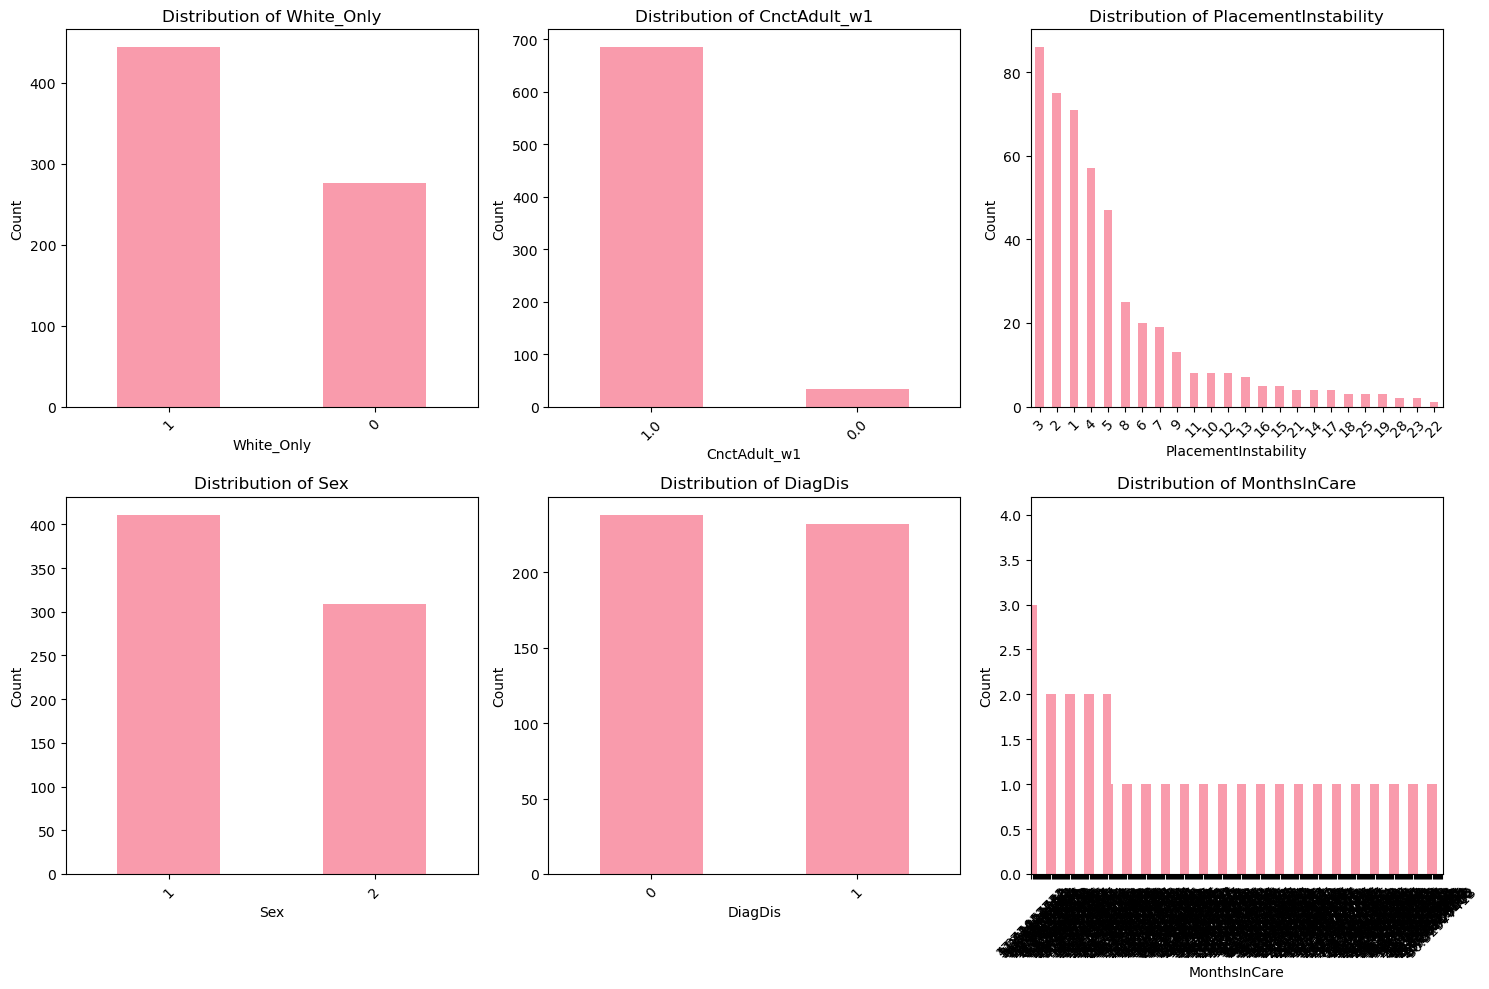

SUMMARY OF SIGNIFICANT RESULTS

Total significant effects found: 19
Outcomes analyzed: 6
Unique variables with significant effects: 9

STRONGEST EFFECTS (by absolute coefficient)

const → SubAbuse_w23
  Coefficient: -3.516 (p=0.0032)
  Effect: const decreases SubAbuse_w23 by 3.516 units

const → CnctAdult_w23
  Coefficient: 2.973 (p=0.0329)
  Effect: const increases CnctAdult_w23 by 2.973 units

const → Children_NoMarriage_w23
  Coefficient: -2.621 (p=0.0096)
  Effect: const decreases Children_NoMarriage_w23 by 2.621 units

CnctAdult_w1 → CnctAdult_w23
  Coefficient: 1.336 (p=0.0324)
  Effect: CnctAdult_w1 increases CnctAdult_w23 by 1.336 units

Sex → Incarc_w23
  Coefficient: -1.157 (p=0.0000)
  Effect: Sex decreases Incarc_w23 by 1.157 units

MOST SIGNIFICANT EFFECTS (by p-value)

Sex → Incarc_w23 (p=0.000004)
  Coefficient: -1.157
  95% CI: [-1.650, -0.664]

PlacementType_3 → Incarc_w23 (p=0.000104)
  Coefficient: 1.116
  95% CI: [0.553, 1.680]

PlacementType_2 → Incarc_w23 (p=0.000

In [199]:
# Cell 9: Data exploration for significant variables in main dataset
# Get unique variables (excluding 'const')
unique_vars = [var for var in significant_model_results['Variable'].unique() if var != 'const']
available_vars = [var for var in unique_vars if var in wave_service_afcars.columns]

print(f"Variables to explore from main dataset: {available_vars}")

if available_vars:
    # Create distribution plots
    n_vars = len(available_vars)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.flatten() if n_vars > 1 else [axes]
    else:
        axes = axes.flatten()
    
    for i, var in enumerate(available_vars):
        if wave_service_afcars[var].dtype in ['int64', 'Int64', 'float64']:
            # Numeric variable
            wave_service_afcars[var].hist(bins=30, alpha=0.7, ax=axes[i], edgecolor='black')
            axes[i].set_title(f'Distribution of {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Frequency')
        else:
            # Categorical variable
            wave_service_afcars[var].value_counts().plot(kind='bar', ax=axes[i], alpha=0.7)
            axes[i].set_title(f'Distribution of {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for i in range(len(available_vars), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Cell 10: Summary Tables and Key Insights
print("="*80)
print("SUMMARY OF SIGNIFICANT RESULTS")
print("="*80)

print(f"\nTotal significant effects found: {len(significant_model_results)}")
print(f"Outcomes analyzed: {len(significant_model_results['Outcome'].unique())}")
print(f"Unique variables with significant effects: {len(significant_model_results['Variable'].unique())}")

print("\n" + "="*50)
print("STRONGEST EFFECTS (by absolute coefficient)")
print("="*50)
strongest_effects = significant_model_results.reindex(
    significant_model_results['Coefficient'].abs().sort_values(ascending=False).index
).head(5)

for _, row in strongest_effects.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"\n{row['Variable']} → {row['Outcome']}")
    print(f"  Coefficient: {row['Coefficient']:.3f} (p={row['P-Value']:.4f})")
    print(f"  Effect: {row['Variable']} {direction} {row['Outcome']} by {abs(row['Coefficient']):.3f} units")

print("\n" + "="*50)
print("MOST SIGNIFICANT EFFECTS (by p-value)")
print("="*50)
most_significant = significant_model_results.nsmallest(5, 'P-Value')

for _, row in most_significant.iterrows():
    print(f"\n{row['Variable']} → {row['Outcome']} (p={row['P-Value']:.6f})")
    print(f"  Coefficient: {row['Coefficient']:.3f}")
    print(f"  95% CI: [{row['CI Lower']:.3f}, {row['CI Upper']:.3f}]")

print("\n" + "="*50)
print("EFFECTS BY OUTCOME")
print("="*50)
for outcome in significant_model_results['Outcome'].unique():
    outcome_data = significant_model_results[significant_model_results['Outcome'] == outcome]
    print(f"\n{outcome}: {len(outcome_data)} significant variables")
    for _, row in outcome_data.iterrows():
        direction = "↑" if row['Coefficient'] > 0 else "↓"
        print(f"  {direction} {row['Variable']}: {row['Coefficient']:.3f} (p={row['P-Value']:.4f})")